# HMC算法相关及如何做动图

## 算法抽样部分

首先，Import各种函数库

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
import matplotlib.animation as animation

定义密度函数并对密度函数（p）取负对数，求梯度

\begin{equation}
grad(-ln(p(x,y)))
\end{equation}

In [3]:
fun=lambda x,y:np.exp(-10*(x**2-y)**2-(y-0.25)**4)#概率密度函数

x,y=sp.symbols('x,y')
prob=sp.exp(-10*(x**2-y)**2-(y-0.25)**4)
U=-sp.log(prob)
Ux=sp.diff(U,x)
Uy=sp.diff(U,y)
gradU=np.vectorize(sp.lambdify([x,y],[Ux,Uy],'numpy'))#把求导结果转化为匿名函数
U=sp.lambdify([x,y],U,'numpy')

定义点数，调整HMC算法的参数以及初始化位置动量向量

In [5]:
Mass=1
iterations=5000
stepsize=0.01
p=np.zeros([iterations,2])
q=np.zeros([iterations,2])
q[0,:]=[-1.5,0.75]

最关键的HMC迭代函数

In [6]:
def HMC(U1,grad_U,epsilon,L,current_q):
    q = current_q
    p = np.random.normal(0,1,q.shape)
    current_p = p
    p = p - (epsilon/2) * grad_U(q[0],q[1])

    for i in range(1,L):
        q = q + epsilon * p
        if i!=L-1:
            p = p - epsilon * grad_U(q[0],q[1])
    
    p = p - (epsilon/2) * grad_U(q[0],q[1])
    p = -p
    current_U=U1(current_q[0],current_q[1])
    current_K=np.sum(current_p**2)/2
    proposed_U=U1(q[0],q[1])
    proposed_K=np.sum(p**2)/2

    if np.random.uniform(0,1)<np.min([1,np.exp(current_U-proposed_U+current_K-proposed_K)]):
        return q
    else:
        return current_q

根据设置的迭代次数，得到所需要的样本点，并计算接受率

In [7]:
for i in range(1,iterations):
    q[i,:]=HMC(U,gradU,stepsize,20,q[i-1,:])

accept_rate=len(set(q[:,1]))/q.shape[0]
print(accept_rate)

0.9998


## 作图部分

Import matplotlib和numpy后基本操作就很matlab差不多了。注释掉的部分是存图的部分，运行极慢，可以参照顾昊生成动图的方式来做动图

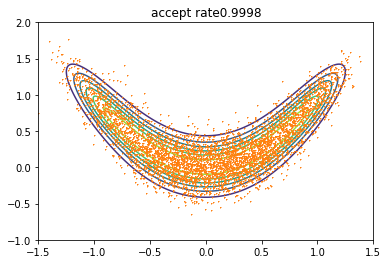

In [8]:
x1=np.linspace(-1.5,1.5,1000)
y1=np.linspace(-1,2,1000)
[X,Y]=np.meshgrid(x1,y1)

fig, ax = plt.subplots()
xdata, ydata = [], []
ln, = plt.plot([], [], '+',markersize=1,animated=True)
plt.plot(q[:,0],q[:,1],'+',markersize=1)

def init():
    ax.set_xlim(-1.5,1.5)
    ax.set_ylim(-1, 2)
    return ln,

def update(frame):
    xdata.append(q[frame,0])
    ydata.append(q[frame,1])
    ln.set_data(xdata, ydata)
    return ln,

plt.title('accept rate'+str(accept_rate))
plt.contour(X,Y,fun(X,Y))
anim = animation.FuncAnimation(fig, update, frames=range(0,iterations),interval=30,
                   init_func=init,blit=True)

#anim.save('example1.gif',writer='imagemagick')
plt.show()

